In [1]:
import os
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import gpt_2_simple as gpt2
import random
import pandas as pd
import numpy as np
import math
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import contextlib
import re

from IPython.display import display_html

sys.path.append("../lib/InferSent")
from models import InferSent
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
import spacy
import torch
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from matplotlib import pyplot as plt
import seaborn as sns

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



[nltk_data] Downloading package punkt to /home/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Bad key "text.kerning_factor" on line 4 in
/home/ryan/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load('../models/encoder/infersent2.pkl'))
infersent.set_w2v_path("../models/fastText/crawl-300d-2M.vec")

nlp = spacy.load("en")
squad_df = pd.read_csv("../corpora/squad-dev-v2.0.csv", index_col=0)

sentences = []

contexts = list(squad_df["contexts"].drop_duplicates())
for context in contexts:
    doc = nlp(context)
    sentences += [sentence.string.strip() for sentence in doc.sents]
    
infersent.build_vocab(sentences, tokenize=True)

Found 18481(/19809) words with w2v vectors
Vocab size : 18481


In [3]:
def cosine_similarity(text1, text2):
    return np.dot(text1, text2)/(np.linalg.norm(text1) * np.linalg.norm(text2))

In [4]:
def split_sentences(paragraph):
    doc = nlp(paragraph)
    return [sentence.string.strip() for sentence in doc.sents]

In [5]:
def cosine_predict(statements, question):
    context_sentences = split_sentences(statements)
    most_similar, highest_sim = "", 0
    for sentence in context_sentences:
        similarity = cosine_similarity(infersent.encode([question])[0], infersent.encode([sentence])[0])
        if similarity > highest_sim:
            most_similar = sentence
            highest_sim = similarity
    return most_similar, highest_sim

In [6]:
profiles = {"default": {}}
profile_dir = "../corpora/profiles"
for profile in os.listdir(profile_dir):
    df = pd.read_csv(f"{profile_dir}/{profile}")
    character = df.columns.tolist()[0]
    profiles[character] = {}
    for emotion in df.columns.tolist()[1:]:
        profiles["default"][emotion] = 1 / len(df.columns.tolist()[1:])
        profiles[character][emotion] = df[emotion].tolist()[0]

In [7]:
def get_emotional_composite(emotional_profile, response_length):
    composite_amount = random.randint(1,3)
    emotions, probabilities = zip(*emotional_profile.items())
    response_breakdown = [(str(emotion), math.floor(response_length/composite_amount) + int(i < response_length % composite_amount)) for i, emotion in enumerate(np.random.choice(emotions, composite_amount, p=probabilities))]
    return response_breakdown

In [8]:
def generate_composite_response(sess, emotional_profile, conversation, character, response_length=30, filtered=True, scene=[]):
    response = "\n".join([f"{sentence[0]}: {sentence[1]}" for sentence in conversation]) + f"\nscene:{', '.join(scene)}\n{character}:"
    start_offset = len(response)
    response_breakdown = get_emotional_composite(emotional_profile, response_length)
    for emotion, length in response_breakdown:
        gpt2.reset_session(sess)
        sess = gpt2.start_tf_sess()
        gpt2.load_gpt2(sess, run_name=f"{emotion}_run1")
        response = gpt2.generate(
            sess,
            length=length,
            temperature=0.7,
            prefix=response,
            nsamples=1,
            batch_size=1,
            run_name=f"{emotion}_run1",
            return_as_list=True
        )[0]
    return re.split(r"[a-z A-Z0-9]+:", response[start_offset:])[0].strip().split("\n")[0] if filtered else response

In [9]:
def generate_character_response(sess, profile, conversation, character, response_length=30, filtered=True, scene=[]):
    seed = "\n".join([f"{sentence[0]}: {sentence[1]}" for sentence in conversation]) + f"\nscene:{', '.join(scene)}\n{character}:"
    gpt2.reset_session(sess)
    sess = gpt2.start_tf_sess()
    gpt2.load_gpt2(sess, run_name=f"{character}_run1")
    response = gpt2.generate(
        sess,
        length=response_length,
        temperature=0.7,
        prefix=seed,
        nsamples=1,
        batch_size=1,
        run_name=f"{character}_run1",
        return_as_list=True
    )[0][len(seed):]
    return re.split(r"[a-z A-Z0-9]+:", response)[0].strip().split("\n")[0] if filtered else response

In [10]:
def generate_holistic_model_response(sess, profile, conversation, character, response_length=30, filtered=True, scene=[]):
    seed = "\n".join([f"{sentence[0]}: {sentence[1]}" for sentence in conversation]) + f"\nscene:{', '.join(scene)}\n{character}:"
    gpt2.reset_session(sess)
    sess = gpt2.start_tf_sess()
    gpt2.load_gpt2(sess, run_name=f"full_model_run1")
    response = gpt2.generate(
        sess,
        length=response_length,
        temperature=0.7,
        prefix=seed,
        nsamples=1,
        batch_size=1,
        run_name=f"full_model_run1",
        return_as_list=True
    )[0][len(seed):]
    return re.split(r"[a-z A-Z0-9]+:", response)[0].strip().split("\n")[0] if filtered else response

In [11]:
def start_conversation(
    conversation=[], 
    scene=["harry", "user", "environment"], 
    characters=["harry", "ron", "hermione", "snape", "albus dumbledore", "tom riddle", "hagrid", "user", "environment"],
    character_addition_prob=0.2,
    character_removal_prob=0.25,
    env_model=generate_character_response, 
    char_model=generate_composite_response, 
    length=10,
    response_length=30,
    filtered=True,
    print_scene=False,
    profiles=profiles,
    end_on_empty=True,
    write_to_file=False,
    file_name="conversation.txt"
):
    print("Scene:")
    [print(f"\t{character}: {statement}") for character, statement in conversation]
    print("")
    sess = gpt2.start_tf_sess()
    with open(f"output/{file_name}", "w", buffering=1) as output_writer:
        [output_writer.write(f"{character}: {statement}\n") for character, statement in conversation]
        for i in range(length):
            if i and random.random() < character_removal_prob and len(scene):
                del scene[scene.index(random.choice(scene))]
            if i and random.random() < character_addition_prob and len(scene) != len(characters):
                scene.append(random.choice([character for character in characters if character not in scene]))
            if not scene and end_on_empty:
                break
            elif not scene and not end_on_empty:
                scene = [random.choice(characters)]
            with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                character = random.choice([character for character in scene if len(scene) < 2 or not conversation or character != conversation[-1][0]])
                if character == "user":
                    print("user: ", end="")
                    response = input("user: ")
                elif character == "environment":
                    response = env_model(sess, profiles[character] if character in profiles else profiles["default"], conversation[-30:], "environment", response_length=response_length, filtered=filtered, scene=scene)
                else:
                    response = char_model(sess, profiles[character] if character in profiles else profiles["default"], conversation[-30:], character, response_length=response_length, filtered=filtered, scene=scene)
            if character != "user":
                print(f"{character.capitalize()}: {response}{' - ' + str(scene) if print_scene else ''}")
            conversation.append((character, response))
            if write_to_file:
                output_writer.write(f"{character.capitalize()}: {response}\n")
            if len(conversation) > 5:
                predicted_response, _ = cosine_predict("\n".join([statement for _, statement in conversation[:-1]]), response)
                conversation.append((character, predicted_response))

In [12]:
scene = [
    ("environment", "Diagon Alley was completely empty because of the coronavirus."),
    ("hagrid", "Where is everybody?"),
    ("albus dumbledore", "Hopefully at home."),
]

In [14]:
start_conversation(
    conversation=scene, 
    scene=["harry", "ron", "hermione", "harry_as_voldemort", "environment"], 
    characters=["harry", "ron", "hermione", "snape", "albus dumbledore", "tom riddle", "hagrid", "harry_as_voldemort", "environment"],
    character_addition_prob=0.2,
    character_removal_prob=0.15,
    env_model=generate_holistic_model_response, 
    char_model=generate_holistic_model_response, 
    length=100,
    response_length=30,
    filtered=True,
    print_scene=True,
    profiles=profiles,
    end_on_empty=False,
    write_to_file=True,
    file_name="conversation_100.txt"
)

Scene:
	environment: Diagon Alley was completely empty because of the coronavirus.
	hagrid: Where is everybody?
	albus dumbledore: Hopefully at home.
	ron: They haven't seen each other in years. What if they've come to visit you?
	harry_as_voldemort: They haven't. What would I get if I added wood to their fire?
	hermione: I'd get nothing. Dumbledore turns, walks off with harry.
	hermione: Diagon Alley was completely empty because of the coronavirus.
	hagrid: Here's where you'll get your quills and ink, and over there all your bits and bobs for doing your wizardry.
	hagrid: What if they've come to visit you?
	ron: They've come to visit you!
	ron: What if they've come to visit you?
	hermione: Just then, voices echo and three kids -- ALICIA, FRED, JAMES and HARRY POTTER -- run up.
	hermione: Here's where you'll get your quills and ink, and over there
	harry: I'm going to be a wizard. I'm going to be famous.
	harry: They've come to visit you!
	environment: ron and hermione sit in front of 

KeyboardInterrupt: 

In [92]:
with open("output/conversation_100_holistic_full_debug.txt", "w") as debug_writer:
    for speaker, statement in scene:
        debug_writer.write(f"{speaker}: {statement}\n")

In [93]:
profiles["harry_as_voldemort"] = profiles["tom riddle"]

In [70]:
scene = [
    ("environment", "Diagon Alley was deserted because of the COVID-19 virus pandemic."),
    ("harry", "Where is everybody?"),
    ("hermione", "Hopefully staying at home."),
]

start_conversation(
    conversation=scene, 
    scene=["harry", "ron", "hermione", "harry_as_voldemort", "tom riddle", "environment"], 
    characters=["harry", "ron", "hermione", "snape", "albus dumbledore", "tom riddle", "hagrid", "harry_as_voldemort", "environment"],
    character_addition_prob=0.21,
    character_removal_prob=0.15,
    env_model=generate_holistic_model_response, 
    char_model=generate_holistic_model_response, 
    length=100,
    response_length=40,
    filtered=True,
    print_scene=True,
    profiles=profiles,
    end_on_empty=False,
    write_to_file=False,
    file_name="conversation.txt"
)

# with open("output/conversation_free_form.txt", "w") as debug_writer:
#     for speaker, statement in scene:
#         debug_writer.write(f"{speaker}: {statement}\n")

Scene:
	environment: Diagon Alley was deserted because of the COVID-19 virus pandemic.
	harry: Where is everybody?
	hermione: Hopefully staying at home.

Environment: All eyes on ron. He holds out his hand. - ['harry', 'ron', 'hermione', 'harry_as_voldemort', 'tom riddle', 'environment']
Hermione: You don't think it's safe, Harry, or Hermione, anymore? - ['harry', 'ron', 'hermione', 'harry_as_voldemort', 'tom riddle', 'environment']
Harry_as_voldemort: Just then, the Patronus Caught Fire. The fire ate through the stone, but they're alive. - ['harry', 'hermione', 'harry_as_voldemort', 'tom riddle', 'environment', 'ron']
Tom riddle: No, not really. I mean, it's not very... new... - ['harry', 'hermione', 'harry_as_voldemort', 'tom riddle', 'environment', 'ron']
Hermione: I think it's safe, Tom. It's just that... it's a bit scary, isn't it? - ['harry', 'hermione', 'harry_as_voldemort', 'tom riddle', 'environment', 'ron']
Ron: Harry. I've got news for you. It's not safe. - ['harry', 'hermio

Ron: excuse me, do you mind? - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'snape']
Harry: are you doing magic? - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'snape', 'harry_as_voldemort']
Harry_as_voldemort: going to kill buckbeak. i've got to find him. he's the only one with the secret of flight. - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'harry_as_voldemort']
Environment: as they go, the_snape_ - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'harry_as_voldemort']
Harry_as_voldemort: tom. boy, are you all right? - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'harry_as_voldemort', 'tom riddle']
Hermione: ron, you're Riddle. You're not Harry, you're Ron. - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'harry_as_voldemort', 'tom riddle']
Harry: tom. riddle. you're Tom Riddle. You're not Harry, you're Ron. - ['hermione', 'environment', 'ron', 'hagrid', 'harry', 'harry_as_voldemort', 'tom riddle']
Environment: they approach a house

Snape: you must be Tom Riddle. i designed him. with his parents as his sidekicks. - ['hermione', 'hagrid', 'harry', 'snape', 'albus dumbledore', 'environment', 'harry_as_voldemort', 'tom riddle', 'ron']
Harry: no... i'm not. - ['hermione', 'hagrid', 'harry', 'albus dumbledore', 'environment', 'harry_as_voldemort', 'tom riddle', 'ron']
Ron: that's not it, harry! that's a trick question. tell me, have you ever met a better wizard? - ['hermione', 'hagrid', 'harry', 'albus dumbledore', 'environment', 'harry_as_voldemort', 'tom riddle', 'ron']


In [51]:
def clean_text(content, character=None, length=0):
    content = content.lower().strip()
    if character:
        for name in character.split(" "):
            content = content.replace(name, " ")
    content = re.sub(r"[^a-zA-Z]", " ", str(content))
    content = re.sub(r"[\s\t\n]+", " ", content)
    tokens = [word for word in content.split() if word and word not in stopwords.words("english") and len(word) > length]
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [38]:
isear_df = pd.read_csv("../corpora/isear.csv", header=None)
isear_df.columns = ["emotion", "text", ""]
isear_df = isear_df.drop([""], axis=1)
cleaned_text = [clean_text(text) for text in isear_df["text"].tolist()]

X_train, X_test, Y_train, Y_test = train_test_split(cleaned_text, isear_df["emotion"].tolist(), test_size=0.3, random_state=1)

In [39]:
count_vectorizer = CountVectorizer()
training_counts = count_vectorizer.fit_transform(cleaned_text)
bag_of_words = count_vectorizer.transform(cleaned_text)
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bag_of_words)
log_regression = Pipeline([
        ('vect', count_vectorizer), 
        ('tfidf', tfidf_transformer),
        ('clf', SGDClassifier(loss="log", 
                              penalty='l1',
                              random_state=1
                             ))
    ])

log_regression.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                       

In [47]:
character_list = ["harry", "ron", "hermione", "snape", "albus dumbledore", "hagrid", "harry_as_voldemort", "tom riddle"]

In [48]:
def display_dataframes_inline(*dataframes):
    inline_df = "".join([df.to_html() for df in dataframes]).replace("table", "table style='display: inline'")
    display_html(inline_df, raw=True)

In [49]:
harry_potter_df = pd.concat([pd.read_csv(f"../corpora/harry_potter/harry_potter_{book}.csv") for book in range(1,4)])

In [53]:
character_top_words = {}
for character in character_list:
    if "_" in character:
        continue
    cleaned_text = [clean_text(text, " ".join(harry_potter_df.character.unique().tolist()), length=2) for text in harry_potter_df[harry_potter_df.character == character]["statement"].tolist()]

    count_vectorizer = CountVectorizer()
    training_counts = count_vectorizer.fit_transform(cleaned_text)
    bag_of_words = count_vectorizer.transform(cleaned_text)

    tfidf_transformer.fit(bag_of_words)
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(),columns=["idf_weights"])
    df_idf.index.name = character
    character_top_words[character] = df_idf.sort_values(by=['idf_weights']).head(15)
    
display_dataframes_inline(*[df for _, df in character_top_words.items()])

,idf_weights
harry,
know,3.961274
one,3.994064
eyes,3.994064
looks,4.137165
think,4.217208
like,4.217208
night,4.259767
see,4.259767
get,4.304219


In [97]:
def get_class_probs(classifier, data):
    prob_spread = classifier.predict_proba([data]).tolist()[0] if hasattr(classifier, "predict_proba") else None
    probabilities = pd.DataFrame({"class": classifier.classes_, "probability": prob_spread})
    probabilities = probabilities.sort_values(by="probability", ascending=False)
    probabilities = probabilities.set_index("class").T.reset_index()
    del probabilities["index"]
    probabilities["predicted"] = log_regression.predict([data])
    return probabilities

In [155]:
def get_emotion_breakdown(text, character_list=character_list):
    scene_df = pd.read_csv(text, sep=": ", names=["character", "statement"])
    generated_character_profiles = {}
    for character in character_list:
        emotion_breakdown = pd.concat([get_class_probs(log_regression, row.statement) for i, row in scene_df[scene_df.character.str.lower() == character].iterrows()], sort=False)
        generated_character_profiles[character] = pd.DataFrame(emotion_breakdown.mean()).T
        generated_character_profiles[character].index.name = character
        generated_character_profiles[character] = generated_character_profiles[character].T.rename(columns={0: "percent"}).sort_values(by="percent", ascending=False)
    generated_character_profiles["tom riddle"] = generated_character_profiles["tom riddle"].rename_axis("tom riddle", axis=1)
    generated_character_profiles["tom riddle"].index.name = None
    display_dataframes_inline(*[df for _, df in generated_character_profiles.items()])
    return generated_character_profiles

composite_profiles = get_emotion_breakdown("output/conversation_30_composite.txt")
individual_profiles = get_emotion_breakdown("output/conversation_100_single_char_1.txt")
holistic_profiles = get_emotion_breakdown("output/conversation_200.txt")

/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


harry,percent
shame,0.259586
sadness,0.190907
guilt,0.143387
disgust,0.143171
anger,0.112967
fear,0.107034
joy,0.042948
ron,percent
disgust,0.506913
shame,0.207889


/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


harry,percent
joy,0.177760
shame,0.161775
disgust,0.150692
anger,0.141546
guilt,0.129243
sadness,0.124204
fear,0.114781
ron,percent
anger,0.197913
guilt,0.161392


/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


harry,percent
joy,0.185362
fear,0.167128
shame,0.157771
guilt,0.134952
disgust,0.129723
anger,0.125723
sadness,0.099341
ron,percent
disgust,0.182333
anger,0.161311


In [104]:
expected_profiles = {}
profile_dir = "../corpora/profiles"
for profile in os.listdir(profile_dir):
    expected_profiles[profile[:-4]] = pd.read_csv(f"{profile_dir}/{profile}").T
    header = expected_profiles[profile[:-4]].iloc[0]
    expected_profiles[profile[:-4]] = expected_profiles[profile[:-4]][1:]
    expected_profiles[profile[:-4]].columns = header
display_dataframes_inline(*[df for _, df in expected_profiles.items()])

tom riddle,percent
fear,0.219053
anger,0.158987
shame,0.140221
disgust,0.133587
guilt,0.133363
joy,0.114099
sadness,0.10069
harry,percent
disgust,0.1648
anger,0.156473


In [105]:
def character_similarity(character_profile_1, character_profile_2):
    return cosine_similarity(character_profile_1.sort_index().T.values[0].tolist(), character_profile_2.sort_index().T.values[0].tolist())

In [196]:
def get_book_similarity(generated_character_profiles, model_name, character_list=character_list):
    similarity_list = []
    for character in character_list:
        expected_character = character[character.rfind("_") + 1 if character.find("_") > 0 else 0:].replace("voldemort", "tom riddle")
        similarity_list.append(character_similarity(generated_character_profiles[character], expected_profiles[expected_character]))

    df = pd.DataFrame({"character": character_list, "book_similarity": similarity_list})
    df.index.name = model_name
    return df

display_dataframes_inline(*[get_book_similarity(composite_profiles, "composite"), get_book_similarity(individual_profiles, "individual"), get_book_similarity(holistic_profiles, "holistic")])

,character,book_similarity
composite,,
0,harry,0.906905
1,ron,0.724984
2,hermione,0.908331
3,snape,0.736106
4,albus dumbledore,0.924878
5,hagrid,0.942674
6,harry_as_voldemort,0.683473
7,tom riddle,0.892414
,character,book_similarity


In [124]:
generated_character_profiles["tom riddle"].reset_index()

tom riddle,index,percent
0,guilt,0.278074
1,fear,0.265438
2,anger,0.204821
3,shame,0.097406
4,sadness,0.082165
5,disgust,0.055400
6,joy,0.016696


In [146]:
expected_prof = expected_profiles["tom riddle"].reset_index()
expected_prof.rename(columns = {"index":"emotion"}, inplace = True) 
expected_prof.percent = expected_prof.percent.apply(pd.to_numeric)
expected_prof

tom riddle,emotion,percent
0,fear,0.219053
1,anger,0.158987
2,shame,0.140221
3,disgust,0.133587
4,guilt,0.133363
5,joy,0.114099
6,sadness,0.100690


In [157]:
def convert_profile(profile, name):
    generated = profile.reset_index()
    generated.rename(columns = {"index": "emotion"}, inplace = True) 
    generated.percent = generated.percent.apply(pd.to_numeric)
    generated["model"] = name
    return generated

In [166]:
from jupyterthemes import jtplot
jtplot.style()

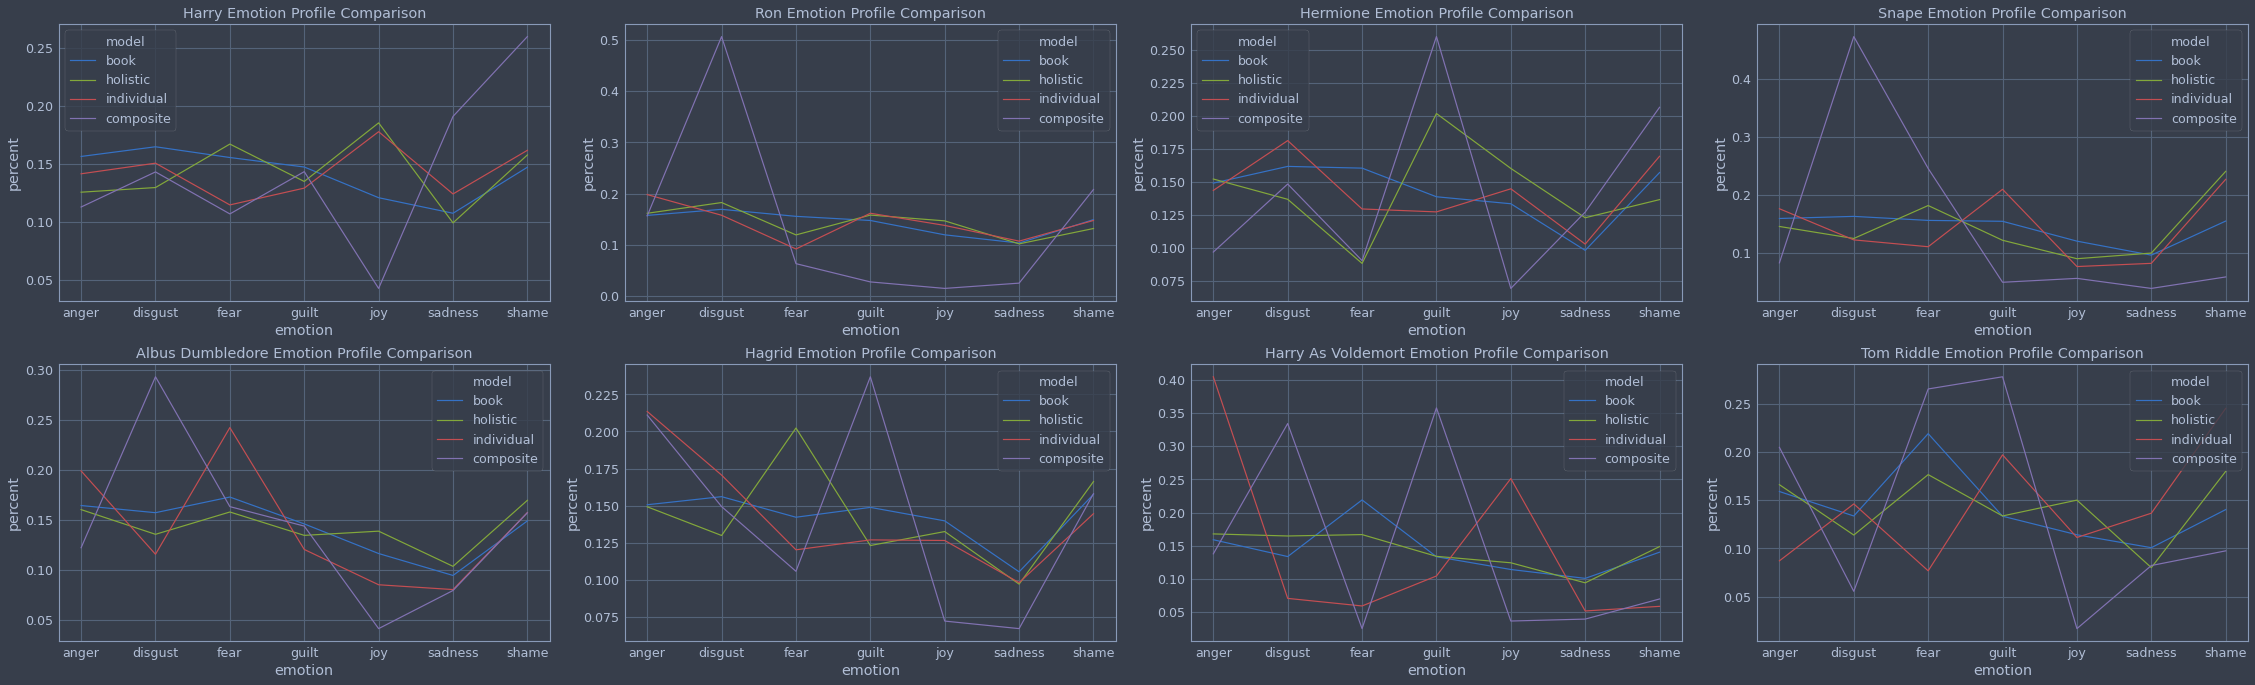

In [193]:
fig, ax = plt.subplots(2,4, figsize=(32,10))
fig.tight_layout(pad=3.0)
for i, character in enumerate(character_list):
    
    expected = convert_profile(expected_profiles[character if "_" not in character else character[character.rfind("_")+1:].replace("voldemort", "tom riddle")], "book")
    holistic = convert_profile(holistic_profiles[character], "holistic")
    individual = convert_profile(individual_profiles[character], "individual")
    composite = convert_profile(composite_profiles[character], "composite")

    df = pd.concat([expected, holistic, individual, composite])

    profile_chart = sns.lineplot(
        x="emotion",
        y="percent",
        hue="model",
        data=df,
        legend="full",
        ax=ax[int(i/4)][i%4]
    ).set_title(f"{' '.join([name.capitalize() for name in re.split(r'[ _]', character)])} Emotion Profile Comparison")